In [2]:
#importer findspark
import findspark
findspark.init()

#importer les modules
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

#creer une session
appName = "TP1: Kmeans avec spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#lire dataset
data = spark.read.csv(
    'C:/Users/MAS/Desktop/2CS-SIL/BDM/dataset/Seed_Data.csv', inferSchema=True, header=True)
data.show(10)

+-----+-----+------+-----+-----+------+-----+------+
|    A|    P|     C|   LK|   WK|A_Coef|  LKG|target|
+-----+-----+------+-----+-----+------+-----+------+
|15.26|14.84| 0.871|5.763|3.312| 2.221| 5.22|     0|
|14.88|14.57|0.8811|5.554|3.333| 1.018|4.956|     0|
|14.29|14.09| 0.905|5.291|3.337| 2.699|4.825|     0|
|13.84|13.94|0.8955|5.324|3.379| 2.259|4.805|     0|
|16.14|14.99|0.9034|5.658|3.562| 1.355|5.175|     0|
|14.38|14.21|0.8951|5.386|3.312| 2.462|4.956|     0|
|14.69|14.49|0.8799|5.563|3.259| 3.586|5.219|     0|
|14.11| 14.1|0.8911| 5.42|3.302|   2.7|  5.0|     0|
|16.63|15.46|0.8747|6.053|3.465|  2.04|5.877|     0|
|16.44|15.25| 0.888|5.884|3.505| 1.969|5.533|     0|
+-----+-----+------+-----+-----+------+-----+------+
only showing top 10 rows



In [3]:
#supprimer la colonne target
x=data.drop('target').collect()
df = spark.createDataFrame(x)
df.show(5)

+-----+-----+------+-----+-----+------+-----+
|    A|    P|     C|   LK|   WK|A_Coef|  LKG|
+-----+-----+------+-----+-----+------+-----+
|15.26|14.84| 0.871|5.763|3.312| 2.221| 5.22|
|14.88|14.57|0.8811|5.554|3.333| 1.018|4.956|
|14.29|14.09| 0.905|5.291|3.337| 2.699|4.825|
|13.84|13.94|0.8955|5.324|3.379| 2.259|4.805|
|16.14|14.99|0.9034|5.658|3.562| 1.355|5.175|
+-----+-----+------+-----+-----+------+-----+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import monotonically_increasing_id 
#creer un indexe pour identifier les lignes
df_index = df.select("*").withColumn("id", monotonically_increasing_id())
df_index.show(10)

+-----+-----+------+-----+-----+------+-----+---+
|    A|    P|     C|   LK|   WK|A_Coef|  LKG| id|
+-----+-----+------+-----+-----+------+-----+---+
|15.26|14.84| 0.871|5.763|3.312| 2.221| 5.22|  0|
|14.88|14.57|0.8811|5.554|3.333| 1.018|4.956|  1|
|14.29|14.09| 0.905|5.291|3.337| 2.699|4.825|  2|
|13.84|13.94|0.8955|5.324|3.379| 2.259|4.805|  3|
|16.14|14.99|0.9034|5.658|3.562| 1.355|5.175|  4|
|14.38|14.21|0.8951|5.386|3.312| 2.462|4.956|  5|
|14.69|14.49|0.8799|5.563|3.259| 3.586|5.219|  6|
|14.11| 14.1|0.8911| 5.42|3.302|   2.7|  5.0|  7|
|16.63|15.46|0.8747|6.053|3.465|  2.04|5.877|  8|
|16.44|15.25| 0.888|5.884|3.505| 1.969|5.533|  9|
+-----+-----+------+-----+-----+------+-----+---+
only showing top 10 rows



In [5]:
from pyspark.ml.feature import VectorAssembler
#assembler les donnees
assembler = VectorAssembler(inputCols = [ "A", "P", "C", "LK","WK","A_Coef","LKG"],outputCol="features")
df_kmeans = assembler.transform(df_index).select('id', 'features')
df_kmeans.show(10)

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[15.26,14.84,0.87...|
|  1|[14.88,14.57,0.88...|
|  2|[14.29,14.09,0.90...|
|  3|[13.84,13.94,0.89...|
|  4|[16.14,14.99,0.90...|
|  5|[14.38,14.21,0.89...|
|  6|[14.69,14.49,0.87...|
|  7|[14.11,14.1,0.891...|
|  8|[16.63,15.46,0.87...|
|  9|[16.44,15.25,0.88...|
+---+--------------------+
only showing top 10 rows



In [8]:
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from pyspark.ml.clustering import KMeans

#determiner le nombre de clusters K avec la methode silouette k>=3
silhouette = []
cost = np.zeros(10)
for k in range(3,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
     
    #predictions
    predictions = model.transform(df_kmeans)

    # Evaluer le clustering avec Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette.append(evaluator.evaluate(predictions)) 
    
print("Silhouette avec distance euclidienne carree : " + str(silhouette))

Silhouette avec distance euclidienne carree : [0.6632174368466226, 0.5943133167452765, 0.5984156343928164, 0.5508426321752656, 0.5017658196992474, 0.5421738576533621, 0.48738960761184547]


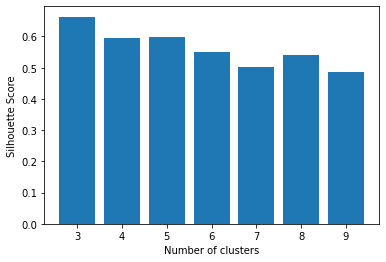

In [9]:
import matplotlib.pyplot as plt

#visualisation des resultats
k = [3, 4, 5, 6,7,8,9] 
plt.bar(k, silhouette) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [10]:
#Appliquer l'algorithme kMeans avec K=3
kmeans = KMeans(
    featuresCol=assembler.getOutputCol(), 
    predictionCol="cluster", k=3)
model = kmeans.fit(df_kmeans)

In [11]:
#imprimer les centres des 3 classes
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[18.72180328 16.29737705  0.88508689  6.20893443  3.72267213  3.60359016
  6.06609836]
[14.64847222 14.46041667  0.87916667  5.56377778  3.27790278  2.64893333
  5.19231944]
[11.96441558 13.27480519  0.8522      5.22928571  2.87292208  4.75974026
  5.08851948]


In [12]:
#classification des donnees selon les 3 classes
prediction = model.transform(df_kmeans)
#compter les members dans chaque cluster
prediction.groupBy("cluster").count().orderBy("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|   61|
|      1|   72|
|      2|   77|
+-------+-----+



In [22]:
#afficher les membres avec ces classes d'association
prediction.select('id', 'cluster').show(10)

+---+-------+
| id|cluster|
+---+-------+
|  0|      1|
|  1|      1|
|  2|      1|
|  3|      1|
|  4|      1|
|  5|      1|
|  6|      1|
|  7|      1|
|  8|      1|
|  9|      1|
+---+-------+
only showing top 10 rows



In [31]:
%matplotlib inline
import pandas as pd
import seaborn as sns

visualised_data=prediction
visualised_data = visualised_data.join(df_index, 'id')
visualised_data= df.limit(210).toPandas()
sns.lmplot(x='A', y='C', data=visualised_data, hue='cluster', aspect=1.5, fit_reg=False)

KeyError: "['cluster'] not in index"

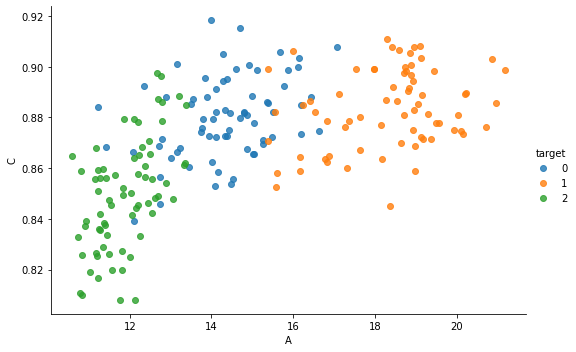

In [30]:
%matplotlib inline
import pandas as pd
import seaborn as sns

visualised_data= data.toPandas()
sns.lmplot(x='A', y='C', data=visualised_data, hue='target', aspect=1.5, fit_reg=False)